In [ ]:
import pandas as pd

vcf_file_path = 'D:/Study/Hi-C_data/syri_zanu_arab.vcf'
def get_vcf_names(vcf_path):
    with open(vcf_path, "rt") as ifile:
          for line in ifile:
            if line.startswith("#CHROM"):
                  vcf_names = [x for x in line.split('\t')]
                  break
    ifile.close()
    return vcf_names


names = get_vcf_names(vcf_file_path)
vcf = pd.read_csv(vcf_file_path, comment='#', delim_whitespace=True, header=None, names=names)
vcf

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,sample\n
0,2L,1,NOTAL1,N,<NOTAL>,.,PASS,END=136047;ChrB=.;StartB=.;EndB=.;Parent=.;Var...,GT,1
1,2L,136048,TRANS1025,N,<TRANS>,.,PASS,END=138381;ChrB=3L;StartB=2459090;EndB=2461444...,GT,1
2,2L,136048,TRANSAL38853,N,<TRANSAL>,.,PASS,END=138381;ChrB=3L;StartB=2459090;EndB=2461444...,GT,1
3,2L,136218,SNP37661,C,T,.,PASS,END=136218;ChrB=3L;StartB=2459260;EndB=2459260...,GT,1
4,2L,136323,SNP37662,A,T,.,PASS,END=136323;ChrB=3L;StartB=2459365;EndB=2459365...,GT,1
...,...,...,...,...,...,...,...,...,...,...
3181821,unscaffolded_ctg_7,254327,SNP3138334,G,A,.,PASS,END=254327;ChrB=unscaffolded_ctg_3;StartB=5661...,GT,1
3181822,unscaffolded_ctg_7,254332,SNP3138335,T,G,.,PASS,END=254332;ChrB=unscaffolded_ctg_3;StartB=5661...,GT,1
3181823,unscaffolded_ctg_7,254430,INS3138336,C,CATCT,.,PASS,END=254430;ChrB=unscaffolded_ctg_3;StartB=5671...,GT,1
3181824,unscaffolded_ctg_7,254569,SNP3138337,T,C,.,PASS,END=254569;ChrB=unscaffolded_ctg_3;StartB=5686...,GT,1


In [ ]:
vcf['sv_len'] = vcf.ALT.apply(len)
vcf['pos_res'] = vcf.POS // 5000

In [ ]:

svs = vcf[['#CHROM', 'pos_res', 'sv_len']].groupby(['#CHROM', 'pos_res']).aggregate({'sv_len':"sum", 
                                                                               '#CHROM':lambda x: x.head(1),
                                                                               'pos_res':lambda x: x.head(1)}).reset_index(drop=True)
svs = svs.sort_values(['#CHROM','pos_res']).reset_index(drop=True)
svs

,sv_len,#CHROM,pos_res
0,7,2L,0
1,123,2L,27
2,46,2L,41
3,61,2L,45
4,64,2L,62
...,...,...,...
36475,33,unscaffolded_ctg_7,22
36476,136,unscaffolded_ctg_7,25
36477,35,unscaffolded_ctg_7,40
36478,28,unscaffolded_ctg_7,47


In [ ]:
svs.pos_res *= 5000

In [ ]:
start  = svs.head(1).pos_res.loc[0]
cur_chr = svs.head(1)['#CHROM'].loc[0]
cur_len = 0
new_svs = {}
new_svs['CHROM'] = []
new_svs['pos_res'] = []
new_svs['sv_len'] = []

for index, row in svs.iterrows():
    if start + cur_len + 50000>= row.pos_res and cur_chr == row['#CHROM']:
        cur_len = row.pos_res-start + row.sv_len
    else:
        new_svs['CHROM'].append(cur_chr)
        new_svs['pos_res'].append(start)
        new_svs['sv_len'].append(cur_len)
        start  = row.pos_res
        cur_chr = row['#CHROM']
        cur_len = 0

In [ ]:
new_svs = pd.DataFrame(new_svs)
new_svs

,CHROM,pos_res,sv_len
0,2L,0,7
1,2L,135000,0
2,2L,205000,20061
3,2L,310000,5010
4,2L,370000,165038
...,...,...,...
208,X,26810000,100064
209,X,27000000,210059
210,unscaffolded_ctg_3,0,265023
211,unscaffolded_ctg_33,0,105093


In [ ]:
new_svs = new_svs[new_svs.sv_len>5000]

In [ ]:
new_svs['end'] = new_svs.pos_res + new_svs.sv_len
new_svs = new_svs.dropna()
new_svs

C:\Users\vit\AppData\Local\Temp\ipykernel_13224\2851628262.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_svs['end'] = new_svs.pos_res + new_svs.sv_len


,CHROM,pos_res,sv_len,end
2,2L,205000,20061,225061
3,2L,310000,5010,315010
4,2L,370000,165038,535038
6,2L,670000,165052,835052
7,2L,890000,130075,1020075
...,...,...,...,...
208,X,26810000,100064,26910064
209,X,27000000,210059,27210059
210,unscaffolded_ctg_3,0,265023,265023
211,unscaffolded_ctg_33,0,105093,105093


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cooler
import pandas as pd
import os
import sys

module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

from HICT_Patterns.hict.patterns.help_functions import get_genome_coords_single, calculate_diag_means, get_chromosome_coords
from HICT_Patterns.hict.patterns.models import *
local_path = 'D:/Study/HICT/HICT_Patterns/'

In [2]:
df = pd.read_csv('saved_df.csv')
df = df[(df.type != 'SYN') & (abs(df.aend - df.astart) > 50000) & (abs(df.bend - df.bstart) > 50000)]
df.to_csv('D:/Study/HICT/HICT_Patterns/data/ZANU_ARAB/syri_svs.csv')

In [3]:
df

,Unnamed: 0,achr,astart,aend,bchr,bstart,bend,type,anno,lab,col,lw,zorder
111,493,2R,9769547,9825233,2R,9862159,9809824,INV,-,Inversion,#FFA500,0.1,1
125,525,2R,18629937,26435253,2R,26427034,18744925,INV,-,NaN,#FFA500,0.1,1
364,1252,X,94869,297178,X,1843324,1633988,INV,-,NaN,#FFA500,0.1,1
379,1412,X,3021953,3083369,X,15380707,15445384,TRANS,-,NaN,#9ACD32,0.1,1
381,1427,X,3257503,3316932,X,15632740,15696855,TRANS,-,NaN,#9ACD32,0.1,1
382,1428,X,3271469,3332068,X,15649954,15713711,TRANS,-,NaN,#9ACD32,0.1,1
383,1435,X,5763599,13279757,X,10194407,1852206,INV,-,NaN,#FFA500,0.1,1
388,1555,X,13881418,13954966,X,584627,644638,TRANS,-,NaN,#9ACD32,0.1,1
396,1609,X,15080794,17398901,X,12218113,10208394,INV,-,NaN,#FFA500,0.1,1
418,1694,X,20677076,24254705,X,23683429,20675227,INV,-,NaN,#FFA500,0.1,1


In [ ]:
df = pd.read_csv('saved_df_coluzzii_arab.csv')
df = df[(df.type != 'SYN') & (abs(df.aend - df.astart) > 50000) & (abs(df.bend - df.bstart) > 50000)]
df.to_csv('D:/Study/HICT/HICT_Patterns/data/ARAB_vs_Coluzzii/syri_svs.csv')

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\vit\.conda\envs\HICT\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\vit\.conda\envs\HICT\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] Удаленный хост принудительно разорвал существующее подключение
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\vit\.conda\envs\HICT\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\vit\.conda\envs\HICT\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] Удаленный хост принудит

C:\Users\vit\AppData\Local\Temp\ipykernel_22768\2430507626.py:5: RuntimeWarning: divide by zero encountered in log10
  matrix = np.log10(mat_balanced)


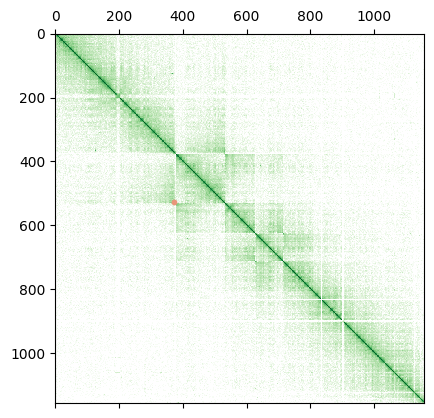

In [19]:
resolution = 50000
c = cooler.Cooler(f'{local_path}data\ARAB_vs_Coluzzii\ARAB_vs_Coluzzii_4DN.mcool::/resolutions/{resolution}')
chr_name = '2R'
mat_balanced = c.matrix(balance=False).fetch(chr_name)
matrix = np.log10(mat_balanced)

results = df[df.achr == chr_name]


fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.matshow(matrix, cmap='Greens')

plt.scatter(results.astart//resolution, results.bstart//resolution,s=10, c='#E9967A')